# SpectralClustering
```
1. 步驟:
    1. 根据数据构造一个 Graph ，Graph 的每一个节点对应一个数据点，将相似的点连接起来，并且边的权重用于表示数据之间的相似度。把这个 Graph 用邻接矩阵的形式表示出来，记为 W 。
    2. 把 的每一列元素加起来得到N 个数，把它们放在对角线上（其他地方都是零），组成一个N*N的矩阵，记为D 。并令L = D - W 。
    3. 求出L的前k个特征值（在本文中，除非特殊说明，否则“前k个”指按照特征值的大小从小到大的顺序）以及对应的特征向量。
    4. 把这k个特征（列）向量排列在一起组成一个N*k的矩阵，将其中每一行看作k维空间中的一个向量，并使用 K-means 算法进行聚类。聚类的结果中每一行所属的类别就是原来 Graph 中的节点亦即最初的N个数据点分别所属的类别。
2. 需要事先指定群數, 群數少效果比較好
3. 應用: 圖像切割
4. 參考資料: http://www.voidcn.com/blog/fenghuangdesire/article/p-5837109.html
            http://www.kfboy.com/2015/06/25/%E8%B0%B1%E8%81%9A%E7%B1%BB%E7%AE%97%E6%B3%95spectral-clustering/
            http://blog.sciencenet.cn/blog-260809-509560.html
            https://www.cs.cmu.edu/~aarti/Class/10701/slides/Lecture21_2.pdf(英文, 講的最詳細~)
```

兩個點的相似度公式


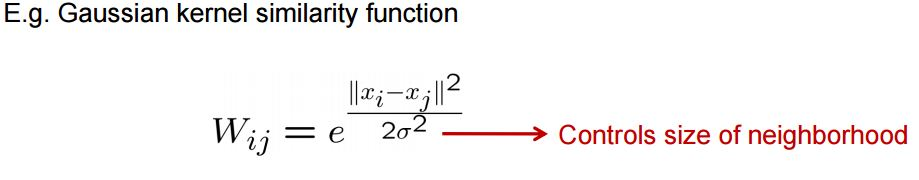

In [1]:
print('兩個點的相似度公式')
from IPython.display import Image
Image(filename='spectral_gaussian.jpg')

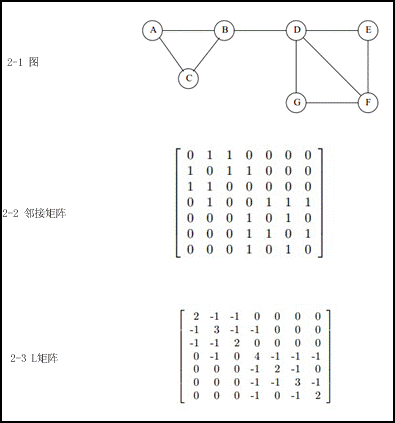

In [2]:
from IPython.display import Image
Image(filename='spectral.jpg')

In [4]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [8]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


In [11]:
# 抓前1000篇文章來分群, 因為3萬篇一樣跑不出來
# 參數affinity用預先計算好的cosin相似矩陣, 

from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer()

pre1000 = apple78Df[:1000]
model = SpectralClustering(13, assign_labels='kmeans', affinity='precomputed')
data = vec.fit_transform(pre1000.term)
simiMx = cosine_similarity(data)
model.fit(simiMx)
predData = pd.Series(model.labels_)
predData.value_counts()
# data = cosine_distances(vec.fit_transform(pre1000))
# data = vec.fit_transform(pre1000)
# labels = spectral_clustering(data, n_clusters=13)
# labels

5     477
0     101
11     98
1      95
8      64
6      44
10     36
2      27
7      23
9      11
4      10
3      10
12      4
dtype: int64

In [13]:
from sklearn import metrics

labels_true, labels = apple78Df[:1000].forum, model.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(simiMx, labels))

Homogeneity: 0.339
Completeness: 0.434
V-measure: 0.381
Adjusted Rand Index: 0.126
Adjusted Mutual Information: 0.317
Silhouette Coefficient: 0.080


In [15]:
grp = 5
print(pre1000[predData == grp].groupby('forum').size())
print('')
pre1000[(predData == grp) & (apple78Df.forum == 'international')] # (apple78Df.forum == 'animal')

forum
3c                 3
animal             4
entertainment     61
fashion           12
finance           37
forum             25
international    127
life              97
local             32
politics          24
property          16
sports            22
strange           17
dtype: int64



,forum,subject,term,keyword,content,pageurl
17,international,【世界一瞬間】風大撩裙第一夫人怕怕,照片 千言萬語 蘋果日報 國內 精彩 新聞 照片 攝影 視角 看透 世界 角落 喜怒哀樂 關...,蜜雪兒 蜜雪兒 攝影 攝影 走光 裸女 車震 世界 世界 第一夫人 保守黨 大將 千言萬語 ...,一張照片勝過千言萬語！？《蘋果日報》搜集每天國內外各地最精彩的新聞照片，帶你透過優秀攝影者的...,http://www.appledaily.com.tw/realtimenews/arti...
57,international,基改作物能救窮人 諾貝爾得主連署力挺,諾貝爾 連署 綠色和平 組織 抵制 基改 作物 飼料 黃金 大米 基改 作物 赤貧 區域 今...,基改 基改 基改 基改 作物 作物 作物 作物 大米 大米 大米 黃金 黃金 黃金 綠色和平...,超過一百名諾貝爾得主連署，要求綠色和平組織停止抵制基改作物與飼料，特別是黃金大米，他們認為基...,http://www.appledaily.com.tw/realtimenews/arti...
72,international,【更新】美總統專機基地槍案 解除部分封鎖,區域 封鎖 醫院 大樓 華盛頓郵報 消息 美國 馬里蘭州 安德魯 空軍基地 時間 上午 槍手...,空軍基地 空軍基地 空軍基地 封鎖 封鎖 封鎖 安德魯 安德魯 演習 演習 基地 基地 大樓...,（部分區域封鎖解除，除了醫院大樓）《華盛頓郵報》消息，美國馬里蘭州安德魯空軍基地當地時間周四...,http://www.appledaily.com.tw/realtimenews/arti...
73,international,【法廣RFI】伊斯坦布爾機場恐襲一華人喪生,法廣 文部 伊斯坦布爾 國際機場 自殺 襲擊 死亡人數 遇難 中有 華人 中國大陸 外交部 ...,伊斯坦布爾 伊斯坦布爾 伊斯坦布爾 伊斯坦布爾 伊斯坦布爾 伊斯坦布爾 土耳其 土耳其 土耳...,本內容由法廣中文部提供伊斯坦布爾國際機場6月28日3起自殺式襲擊造成的死亡人數升至42人，在...,http://www.appledaily.com.tw/realtimenews/arti...
74,international,百年最大原鑽 19.7億流標,Lesedi la Rona 發現 鑽石 原石 克拉 英國 倫敦 蘇富比 拍賣會 投標 美元...,蘇富比 蘇富比 克拉 克拉 cullinan lesedi rona 庫利 原石 礦場 拍賣...,這顆巨鑽稱為「我們的光」（Lesedi la Rona），是百年來發現最大的鑽石原石，有11...,http://www.appledaily.com.tw/realtimenews/arti...
75,international,【法廣RFI】國際能源署:空氣污染致陸人減壽,法廣 文部 南華早報 日報 國際 能源 報告 空氣污染 中國大陸 平均壽命 報告 中國大陸 ...,能源 能源 能源 能源 能源 空氣污染 空氣污染 空氣污染 空氣污染 中國大陸 中國大陸 中...,本內容由法廣中文部提供南華早報今天6月30日報道，國際能源署報告指出：空氣污染導致中國大陸人...,http://www.appledaily.com.tw/realtimenews/arti...
76,international,【法廣RFI】陸網信辦主任被免職留任中宣部,法廣 文部 新華社 昨天 下午 消息 中央 辦公 人事 上海市委 宣傳 中央 魯煒 中央 魯...,上海市 上海市 上海市 上海市 上海市 上海市 上海市 上海市 國家互聯網信息辦公室 國家互...,本內容由法廣中文部提供新華社昨天下午發布消息，中央網信辦公布了一項重要人事調整：2015年6...,http://www.appledaily.com.tw/realtimenews/arti...
77,international,【台灣英文新聞】後脫歐時代「FANG」你一定要再認識,台灣 英文 新聞 英國脫歐公投 脫歐 全球 金融市場 風險 國家 美國 財經 節目主持 美國...,英文 英文 英文 英文 互連網 財經 財經 利牙 fang 網飛 美國 美國 美國 netf...,本內容由台灣英文新聞提供英國脫歐公投的結果脫歐派勝，全球金融市場風險趨避心態濃厚，沒有一個國...,http://www.appledaily.com.tw/realtimenews/arti...
79,international,【數位時代】城市太擁擠、房價又高該怎麼辦？YCombinator：自己蓋一座,數位 時代 美國 科技 新創 孵化器 Combinator 成功 培育 新創 Airbnb ...,cheung cheung cheung combinator combinator com...,本內容由數位時代提供美國知名科技新創孵化器 Y Combinator 過去曾成功培育許多新創...,http://www.appledaily.com.tw/realtimenews/arti...
85,international,【法廣RFI】不會算術法前第一夫人自曝私生活,法廣 文部 法國 總統大選 前總統 薩科齊 新聞 夫人 卡拉 魯尼 法國 女性 雜誌 專訪 ...,魯尼 魯尼 魯尼 魯尼 魯尼 魯尼 魯尼 卡拉 卡拉 卡拉 卡拉 卡拉 卡拉 卡拉 薩科齊 ...,本內容由法廣中文部提供法國明年5月舉行總統大選，前總統薩科齊有意進行角逐的種種動作已不是新聞...,http://www.appledaily.com.tw/realtimenews/arti...


Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
Spectral clustering: kmeans, 8.85s
Spectral clustering: discretize, 6.94s


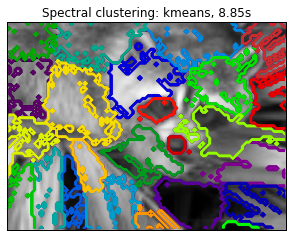

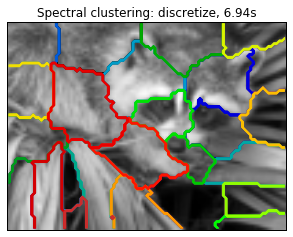

In [6]:
print(__doc__)

# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>, Brian Cheung
# License: BSD 3 clause

import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

if sp_version < (0, 12):
    raise SkipTest("Skipping because SciPy version earlier than 0.12.0 and "
                   "thus does not include the scipy.misc.face() image.")


# load the raccoon face as a numpy array
try:
    face = sp.face(gray=True)
except AttributeError:
    # Newer versions of scipy have face in misc
    from scipy import misc
    face = misc.face(gray=True)

# Resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face, 0.10) / 255.

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(face)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                       
                                 assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(face.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(face, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

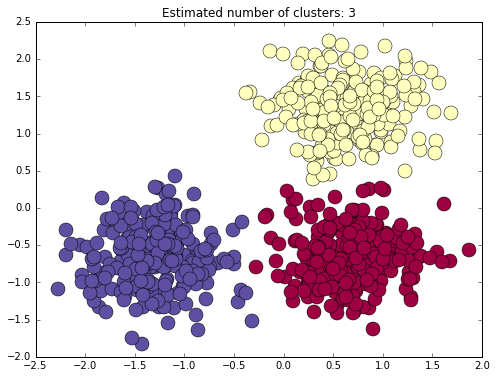

In [7]:
# 仿照DBSCAN的例子產生一樣的資料分群看看, 結果當然是OK的, 看來對付簡單2維幾何都是可以的

from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
clf = SpectralClustering(3)
clf.fit(X)
labels = clf.labels_

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % 3)
plt.show()